## Introduction


The data is a collection of tweets retrieved from Kaggle. The tweets were collected by an individual using the Twitter API, using hashtags to pick tweets containing information about the Pfizer & BioNTech Vaccine.

Link to the original data: https://www.kaggle.com/gpreda/pfizer-vaccine-tweets (In this notebook: Version 119)

The data is around 9000 entries, some of which are unusable for our analysis. While there are bigger datasets with hundreds of thousands of rows available, this dataset was selected because of it's good quality, and the ability to run GeoPy to make inferences about locations.

Most of the cells in this project are made intentionally to combine code as much as possible into one cell. This is to increase readability on the portfolio website where this is posted!

Hopefully you'll enjoy reading this NLP project.


**Table of contents:**
- The Data: Exploratory analysis
    - Data Cleanup
    - Converting time strings to datetime format
- Sentiment Analysis
    - Using Vader-score to understand the sentiment
    - Calculating the followers to following ratio.
    - Regression analysis
- Text cleanup using PorterStemmer and plotting the common words.
- Conclusions


In [1]:
#Load the libraries

import numpy as np
import pandas as pd
import math
import random

from datetime import datetime

#!pip3 install geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.feature_extraction.text import CountVectorizer
import collections

import re, string, os

import nltk
nltk.download('stopwords')
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import matplotlib.dates as mdates

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#!pip3 install researchpy
import researchpy as rp
import scipy.stats as stats


#Load the data
tweet_data_original = pd.read_csv('vaccination_tweets.csv')

[nltk_data] Downloading package stopwords to /Users/tatu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tatu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## The Data: Exploratory analysis

To understand the data, we will perform several checks and cleanup to get the data we want for later analysis. The data needs to be also reviewed in order to choose the types of analysis we can conduct on it.





In [2]:
tweet_data_original.head()[:2]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False


In [3]:
tweet_data_original.info()
tweet_data_original.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9541 entries, 0 to 9540
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9541 non-null   int64 
 1   user_name         9541 non-null   object
 2   user_location     7623 non-null   object
 3   user_description  8944 non-null   object
 4   user_created      9541 non-null   object
 5   user_followers    9541 non-null   int64 
 6   user_friends      9541 non-null   int64 
 7   user_favourites   9541 non-null   int64 
 8   user_verified     9541 non-null   bool  
 9   date              9541 non-null   object
 10  text              9541 non-null   object
 11  hashtags          7295 non-null   object
 12  source            9540 non-null   object
 13  retweets          9541 non-null   int64 
 14  favorites         9541 non-null   int64 
 15  is_retweet        9541 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.0+ MB


,id,user_followers,user_friends,user_favourites,retweets,favorites
count,9.541000e+03,9.541000e+03,9541.000000,9.541000e+03,9541.000000,9541.000000
mean,1.362976e+18,3.618268e+04,1177.470705,1.481357e+04,1.425532,8.176606
std,2.244526e+16,3.100293e+05,2846.392349,4.643485e+04,12.087367,54.859691
min,1.337728e+18,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.346552e+18,1.100000e+02,165.000000,4.110000e+02,0.000000,0.000000
50%,1.354802e+18,4.690000e+02,462.000000,2.300000e+03,0.000000,1.000000
75%,1.373953e+18,2.098000e+03,1228.000000,1.120600e+04,1.000000,4.000000
max,1.423141e+18,1.371493e+07,103226.000000,1.166459e+06,678.000000,2315.000000


In [4]:
tweet_data_original['user_location'].value_counts()

Malaysia                 151
London, England          135
India                    119
London                    93
Canada                    86
                        ... 
Aarde                      1
Into the Wild              1
Balt/Wash DC corridor      1
Tennessee, USA             1
Lisboa, Portugal           1
Name: user_location, Length: 2775, dtype: int64

## Data Cleanup

In [5]:
#Checking the instesting columns for null values and dropping all rows with null values

tweet_data = tweet_data_original[tweet_data_original['user_location'].notna()]
tweet_data = tweet_data[tweet_data['user_description'].notna()]

#Choosing only interesting columns
tweet_data = tweet_data[['user_location','user_description','user_followers','user_friends','user_verified','date','text']]


tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7353 entries, 0 to 9540
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_location     7353 non-null   object
 1   user_description  7353 non-null   object
 2   user_followers    7353 non-null   int64 
 3   user_friends      7353 non-null   int64 
 4   user_verified     7353 non-null   bool  
 5   date              7353 non-null   object
 6   text              7353 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 409.3+ KB


### Using GeoPy to convert locations to country locations

#### This script takes in fact around 1.5 hours to run. It checks for a csv file in the project folder, which if found, will enable the script to skip the data-collection and speed up the running of the notebook.

In [6]:
geopy = RateLimiter(Nominatim(user_agent='xccyyy').geocode, min_delay_seconds=1)

geo_df=pd.DataFrame(columns=['Latitude','Longitude','Country'])

try:
    csv_df=pd.read_csv('geo_df.csv')
    print('csv found')
    print(len(csv_df))
except:
    print('No csv, continuing.')
    csv_df=pd.DataFrame(columns=['Latitude','Longitude','Country'])

loc_list_lat = []
loc_list_lon = []
loc_list_countries = []
counter = 0
found_counter = 0

if len(csv_df) < 6500:
    for location in tweet_data['user_location'].tolist():
    
        counter = counter + 1

        if counter == 10:
            print('10 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 500:
            print('11 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 1000:
            print('1000 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 1500:
            print('1500 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 2000:
            print('2000 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 3000:
            print('3000 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 4000:
            print('4000 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 5000:
            print('5000 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 6000:
            print('6000 done')
            print('Found: ' + str(found_counter))
            print(' ')
        elif counter == 7200:
            print('almost done')

        try:
            place = geopy(location)
            loc_list_lat.append(place.raw['lat'])
            loc_list_lon.append(place.raw['lon'])
            loc_list_countries.append(place.raw['display_name'].split(", ")[-1])
            found_counter = found_counter + 1
        except:
            loc_list_lat.append('None')
            loc_list_lon.append('None')
            loc_list_countries.append('None')

        geo_df['Latitude'] = loc_list_lat
        geo_df['Longitude'] = loc_list_lon
        geo_df['Country'] = loc_list_countries
        geo_df.to_csv('geo_df.csv')

geo_df=pd.read_csv('geo_df.csv')
geo_df.head()


csv found
7353


,Unnamed: 0,Latitude,Longitude,Country
0,0,34.2192742,-118.2318871,United States
1,1,37.7790262,-122.419906,United States
2,2,42.6851664,-2.942752,España
3,3,49.2608724,-123.1139529,Canada
4,4,52.4796992,-1.9026911,United Kingdom


In [7]:
geo_df['Country'].value_counts()[0:10]

United States               1535
United Kingdom              1288
None                         908
Canada                       517
India                        459
Malaysia                     247
الإمارات العربية المتحدة     207
Éire / Ireland               196
Deutschland                  168
France                       132
Name: Country, dtype: int64

## For our analysis we will choose the countries United States, United Kingdom, Canada, India and Malaysia because they have sufficiently large amount of tweets for analysis.

In [8]:
#adding the geo_df to the tweets dataframe

location_data = pd.read_csv('geo_df.csv')
tweet_data = tweet_data[['user_description','user_followers','user_friends','user_verified','date','text']]
tweet_data['Country'] = location_data['Country']
tweet_data['Latitude'] = location_data['Latitude']
tweet_data['Longitude'] = location_data['Longitude']

tweet_data.head()



,user_description,user_followers,user_friends,user_verified,date,text,Country,Latitude,Longitude
0,Aggregator of Asian American news; scanning di...,405,1692,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,United States,34.2192742,-118.2318871
1,"Marketing dude, tech geek, heavy metal & '80s ...",834,666,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,United States,37.7790262,-122.419906
2,"heil, hydra 🖐☺",10,88,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,España,42.6851664,-2.942752
3,"Hosting ""CharlesAdlerTonight"" Global News Radi...",49165,3933,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",Canada,49.2608724,-123.1139529
5,"Gastroenterology trainee, Clinical Research Fe...",105,108,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,None,None,None


### Converting time strings to datetime format

In [9]:
datelist = []
for date in tweet_data['date'].tolist():
    datelist.append(datetime.strptime(date, '%Y-%m-%d %H:%M:%S'))
tweet_data['datetime'] = datelist
del tweet_data['date']
tweet_data.head()

,user_description,user_followers,user_friends,user_verified,text,Country,Latitude,Longitude,datetime
0,Aggregator of Asian American news; scanning di...,405,1692,False,Same folks said daikon paste could treat a cyt...,United States,34.2192742,-118.2318871,2020-12-20 06:06:44
1,"Marketing dude, tech geek, heavy metal & '80s ...",834,666,False,While the world has been on the wrong side of ...,United States,37.7790262,-122.419906,2020-12-13 16:27:13
2,"heil, hydra 🖐☺",10,88,False,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,España,42.6851664,-2.942752,2020-12-12 20:33:45
3,"Hosting ""CharlesAdlerTonight"" Global News Radi...",49165,3933,True,"Facts are immutable, Senator, even when you're...",Canada,49.2608724,-123.1139529,2020-12-12 20:23:59
5,"Gastroenterology trainee, Clinical Research Fe...",105,108,False,Does anyone have any useful advice/guidance fo...,None,None,None,2020-12-12 20:11:42


In [10]:
#Double checking that all the needed data is in correct format!

tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7353 entries, 0 to 9540
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_description  7353 non-null   object        
 1   user_followers    7353 non-null   int64         
 2   user_friends      7353 non-null   int64         
 3   user_verified     7353 non-null   bool          
 4   text              7353 non-null   object        
 5   Country           5654 non-null   object        
 6   Latitude          5654 non-null   object        
 7   Longitude         5654 non-null   object        
 8   datetime          7353 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 524.2+ KB


## Sentiment Analysis

### Using Vader-score to understand the sentiment

In [11]:
#Inspired by several online tutorials, sources missing.

vader = SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = vader.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

#Seeing if Vader works
print_sentiment_scores("Vaccine bad") #Compound value scale = -1 to 1 (-ve to +ve)

Vaccine bad----------------------------- {'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'compound': -0.5423}


In [12]:
def vader_to_list(df,column):
    %time   #to calulate the time it takes the algorithm to compute a VADER score
    i=0
    to_list = [ ] 
    while (i<len(df)):
    
        k = vader.polarity_scores(df.iloc[i][column])
        to_list.append(k['compound'])
        
        i = i+1
        
    return to_list

tweet_data['VADER tweet'] = vader_to_list(tweet_data,'text')
tweet_data['VADER descr'] = vader_to_list(tweet_data,'user_description')

tweet_data.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


,user_description,user_followers,user_friends,user_verified,text,Country,Latitude,Longitude,datetime,VADER tweet,VADER descr
0,Aggregator of Asian American news; scanning di...,405,1692,False,Same folks said daikon paste could treat a cyt...,United States,34.2192742,-118.2318871,2020-12-20 06:06:44,0.4019,0.0000
1,"Marketing dude, tech geek, heavy metal & '80s ...",834,666,False,While the world has been on the wrong side of ...,United States,37.7790262,-122.419906,2020-12-13 16:27:13,-0.1027,0.3182
2,"heil, hydra 🖐☺",10,88,False,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,España,42.6851664,-2.942752,2020-12-12 20:33:45,0.2500,0.0000
3,"Hosting ""CharlesAdlerTonight"" Global News Radi...",49165,3933,True,"Facts are immutable, Senator, even when you're...",Canada,49.2608724,-123.1139529,2020-12-12 20:23:59,0.0000,0.0000
5,"Gastroenterology trainee, Clinical Research Fe...",105,108,False,Does anyone have any useful advice/guidance fo...,None,None,None,2020-12-12 20:11:42,0.7003,0.0000


In [13]:
### Aanalysis: Difference in sentiment between different countries.

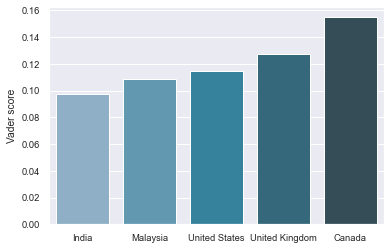

In [14]:
country_comparison=pd.DataFrame(columns=['Country','Vader score'])
country_list = ['United States', 'United Kingdom', 'Canada', 'India', 'Malaysia']
vader_list = []
vader_list.append(tweet_data.loc[tweet_data['Country'] == 'United States']['VADER tweet'].mean())
vader_list.append(tweet_data.loc[tweet_data['Country'] == 'United Kingdom']['VADER tweet'].mean())
vader_list.append(tweet_data.loc[tweet_data['Country'] == 'Canada']['VADER tweet'].mean())
vader_list.append(tweet_data.loc[tweet_data['Country'] == 'India']['VADER tweet'].mean())
vader_list.append(tweet_data.loc[tweet_data['Country'] == 'Malaysia']['VADER tweet'].mean())
country_comparison['Country'] = country_list
country_comparison['Vader score'] = vader_list

#country_comparison.sort_values(by=['Vader score'])

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set(font_scale=0.85)

comparison_graph = sns.barplot(x='Country', y='Vader score', palette="PuBuGn_d", data=country_comparison.sort_values(by=['Vader score'])).set(xlabel=None)
                         
plt.show()





                  


### Canadians seem to be the most positive about the vaccine, while Indians were the most negative in this dataset.

### User analysis: How does the sentiment differ between verified and non-verified users?


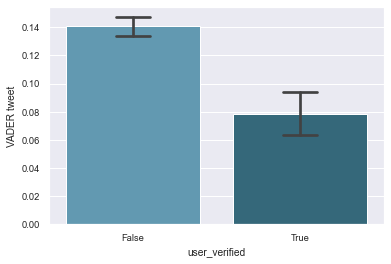

In [15]:
sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
verified = sns.barplot(x="user_verified", y="VADER tweet", data=tweet_data, estimator=np.mean, ci=85, capsize=.2, palette="PuBuGn_d")

plt.show()



### The results seem odd. Testing with T-Test to confirm the result.

In [16]:
rp.ttest(group1= tweet_data['VADER tweet'][tweet_data['user_verified'] == True], group1_name= "Verified",
         group2= tweet_data['VADER tweet'][tweet_data['user_verified'] == False], group2_name= "Non-verified")

(       Variable       N      Mean        SD        SE  95% Conf.  Interval
 0      Verified   789.0  0.078502  0.306532  0.010913   0.057080  0.099923
 1  Non-verified  6564.0  0.140601  0.372281  0.004595   0.131594  0.149609
 2      combined  7353.0  0.133938  0.366278  0.004271   0.125565  0.142311,
                         Independent t-test    results
 0  Difference (Verified - Non-verified) =     -0.0621
 1                    Degrees of freedom =   7351.0000
 2                                     t =     -4.5054
 3                 Two side test p value =      0.0000
 4                Difference < 0 p value =      0.0000
 5                Difference > 0 p value =      1.0000
 6                             Cohen's d =     -0.1698
 7                             Hedge's g =     -0.1697
 8                         Glass's delta =     -0.2026
 9                           Pearson's r =      0.0525)

## The verified users tend to indeed tweet more negative things in this dataset. Maybe we can find an explanation for this...


## Let's see some of these tweets!

In [17]:
verifieds = (tweet_data[['text', 'VADER tweet']][tweet_data['user_verified'] == True])

#verifieds.head()
verifieds.loc[verifieds['VADER tweet'] < -0.2]


,text,VADER tweet
44,#FDA authorizes #PfizerBioNTech #coronavirus v...,-0.3818
192,"Turkey’s coronavirus death toll reaches 16,417...",-0.5719
204,"Turkey’s coronavirus death toll reaches 16,417...",-0.5719
235,The US Food and Drug Administration (FDA) issu...,-0.3818
242,"Global coronavirus death toll reaches 1,611,63...",-0.5719
...,...,...
8328,MoHAP Authorised the Emergency Use of the Pfiz...,-0.3818
8528,"Can @pfizer, @moderna_tx vaccines be gamechang...",-0.6249
8801,"Deliveries of the vaccine, among several brand...",-0.3818
8860,#NSTworld #EU states must use all the #vaccine...,-0.3818


## Many of the negative tweets from the verified accounts seem to be news stories that are not negative about the vaccine itself. It might be more useful to focus our analysis on regular users, who have close to 1:1 followers to following ratio...


### Calculating the followers to following ratio.

In [18]:
#The next function ran into trouble because there were infinite values because of division by zero, let's see why.
(tweet_data.user_friends == 0).sum()

#There seems to be 27 zero values in the dataset. This is not too much to just remove.
popularity_data = tweet_data[tweet_data.user_friends != 0]
popularity_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7326 entries, 0 to 9540
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_description  7326 non-null   object        
 1   user_followers    7326 non-null   int64         
 2   user_friends      7326 non-null   int64         
 3   user_verified     7326 non-null   bool          
 4   text              7326 non-null   object        
 5   Country           5633 non-null   object        
 6   Latitude          5633 non-null   object        
 7   Longitude         5633 non-null   object        
 8   datetime          7326 non-null   datetime64[ns]
 9   VADER tweet       7326 non-null   float64       
 10  VADER descr       7326 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 636.7+ KB


In [19]:
popularity_data['followers_to_following'] = (popularity_data['user_followers'] / popularity_data['user_friends'])
popularity_data.head()

<ipython-input-19-3bc76a8cc0c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popularity_data['followers_to_following'] = (popularity_data['user_followers'] / popularity_data['user_friends'])


,user_description,user_followers,user_friends,user_verified,text,Country,Latitude,Longitude,datetime,VADER tweet,VADER descr,followers_to_following
0,Aggregator of Asian American news; scanning di...,405,1692,False,Same folks said daikon paste could treat a cyt...,United States,34.2192742,-118.2318871,2020-12-20 06:06:44,0.4019,0.0000,0.239362
1,"Marketing dude, tech geek, heavy metal & '80s ...",834,666,False,While the world has been on the wrong side of ...,United States,37.7790262,-122.419906,2020-12-13 16:27:13,-0.1027,0.3182,1.252252
2,"heil, hydra 🖐☺",10,88,False,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,España,42.6851664,-2.942752,2020-12-12 20:33:45,0.2500,0.0000,0.113636
3,"Hosting ""CharlesAdlerTonight"" Global News Radi...",49165,3933,True,"Facts are immutable, Senator, even when you're...",Canada,49.2608724,-123.1139529,2020-12-12 20:23:59,0.0000,0.0000,12.500636
5,"Gastroenterology trainee, Clinical Research Fe...",105,108,False,Does anyone have any useful advice/guidance fo...,None,None,None,2020-12-12 20:11:42,0.7003,0.0000,0.972222


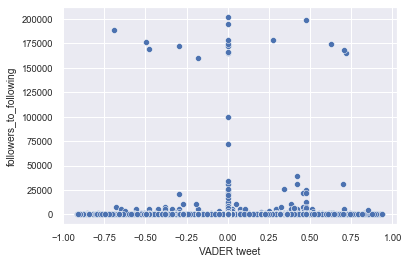

In [20]:
#Let's graph this data

sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
verified = sns.scatterplot(x="VADER tweet", y="followers_to_following", data=popularity_data, palette="PuBuGn_d")

plt.show()

In [21]:
#It seems very scattered. Let's see the descriptive statistics.

popularity_data['followers_to_following'].describe()

count      7326.000000
mean        700.011158
std        9412.303849
min           0.000000
25%           0.396727
50%           0.873588
75%           2.463399
max      202322.000000
Name: followers_to_following, dtype: float64

## The data seems to be very scattered, seemingly no correlation. This is caused by outliers such as celebrities in the data. Let's select only smaller set of data to make inferences.

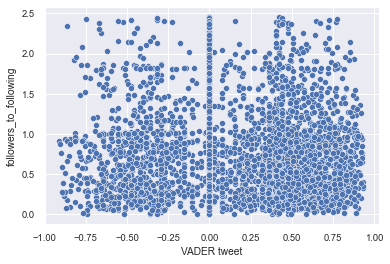

### In the upper right quarter there seems to be higher density of data points. Let us select even smaller subset.


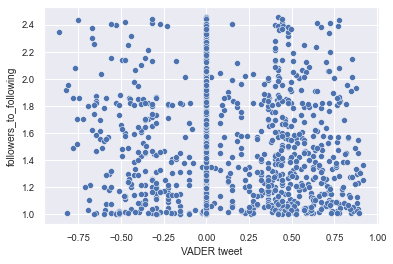

In [22]:
sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
verified = sns.scatterplot(x="VADER tweet", y="followers_to_following", data=popularity_data.loc[popularity_data['followers_to_following'] < 2.46]

, palette="PuBuGn_d")

plt.show()

print('### In the upper right quarter there seems to be higher density of data points. Let us select even smaller subset.')

subset = popularity_data.loc[popularity_data['followers_to_following'] < 2.46]
subset = subset.loc[subset['followers_to_following'] > 1]

sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
verified = sns.scatterplot(x="VADER tweet", y="followers_to_following", data=subset, palette="PuBuGn_d")

plt.show()

## The scatter plot does not seem to have any correlation between data points. Perhaps there is a slight tencendy for the people with followers-to-following ratio between 1.6 to 2.5 to be positive about the vaccine. Let's run a regression analysis to test this.

## Regression analysis

                              OLS Regression Results                              
Dep. Variable:     followers_to_following   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.002
Method:                     Least Squares   F-statistic:                    0.1748
Date:                    Sat, 07 Aug 2021   Prob (F-statistic):              0.676
Time:                            18:21:35   Log-Likelihood:                -5.4052
No. Observations:                     455   AIC:                             14.81
Df Residuals:                         453   BIC:                             23.05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const     

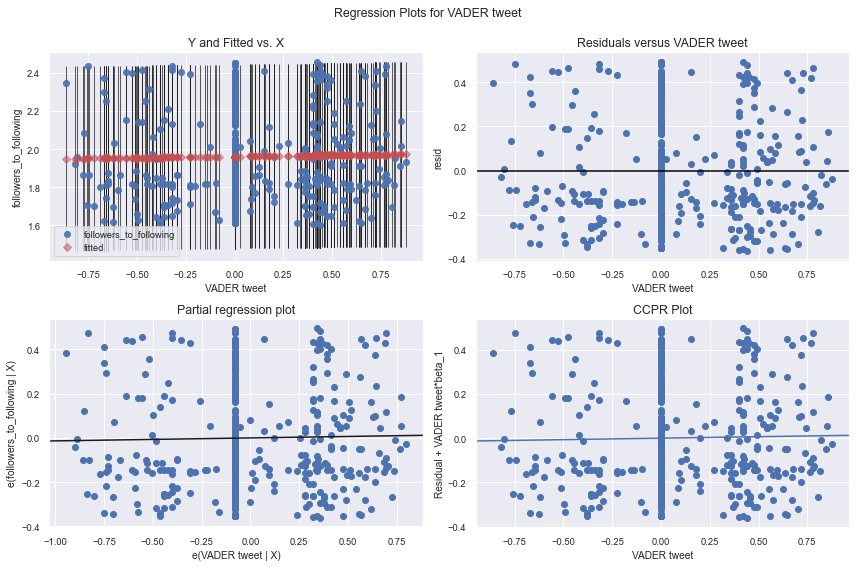

In [23]:
##inspired by https://www.statology.org/simple-linear-regression-in-python/
subset = subset.loc[subset['followers_to_following'] > 1.6]

import statsmodels.api as sm

#define response variable
y = subset['followers_to_following']

#define explanatory variable
x = subset['VADER tweet']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

#define figure size
fig = plt.figure(figsize=(12,8))

#produce residual plots
fig = sm.graphics.plot_regress_exog(model, 'VADER tweet', fig=fig)

plt.show()

### As suspected from the plot, the R-squared is close to zero with very small coefficient.

### There is no correlation between the followers-to-following ratios and the sentiment to vaccine!

## Plotting the sentiment across time.

In [24]:
tweet_data['datetime'].describe()

<ipython-input-24-490c9fec9c96>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tweet_data['datetime'].describe()


count                    7353
unique                   7348
top       2021-01-11 15:40:25
freq                        2
first     2020-12-12 11:55:28
last      2021-08-05 04:00:49
Name: datetime, dtype: object

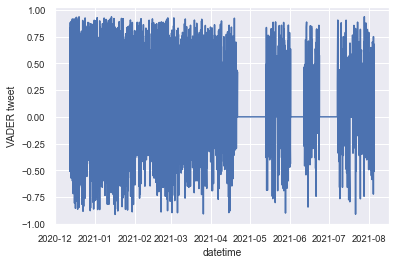

In [25]:
#Plotting the raw data

sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
ax = sns.lineplot(x="datetime", y="VADER tweet", data=tweet_data, palette="PuBuGn_d")

plt.show()


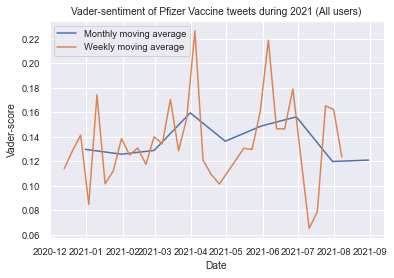

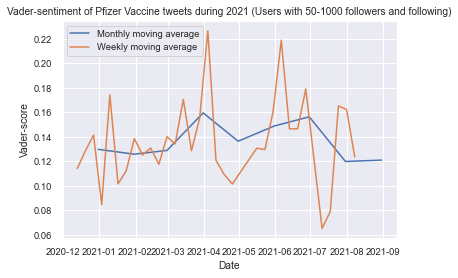

In [26]:
#Moving average: All data

sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
ax = sns.lineplot(x="datetime", y="VADER tweet", data=tweet_data[['datetime','VADER tweet']].groupby(pd.Grouper(key='datetime',freq='M')).mean(), palette="PuBuGn_d")
ax2 = sns.lineplot(x="datetime", y="VADER tweet", data=tweet_data[['datetime','VADER tweet']].groupby(pd.Grouper(key='datetime',freq='W')).mean(), palette="PuBuGn_d")
plt.legend(labels=["Monthly moving average","Weekly moving average"])

ax.set_title('Vader-sentiment of Pfizer Vaccine tweets during 2021 (All users)')
ax.set_xlabel('Date')
ax.set_ylabel('Vader-score')

plt.show()

#Moving average: among users with following 50-1000 users and 50-1000 followers

subset2 = tweet_data.loc[tweet_data['user_followers'] < 1000]
subset2 = subset2.loc[subset2['user_followers'] > 50]
subset2 = subset2.loc[subset2['user_friends'] > 50]
subset2 = subset2.loc[subset2['user_friends'] < 1000]

sns.set(style="darkgrid")
sns.set(font_scale=0.85)
            
ax = sns.lineplot(x="datetime", y="VADER tweet", data=tweet_data[['datetime','VADER tweet']].groupby(pd.Grouper(key='datetime',freq='M')).mean(), palette="PuBuGn_d")
ax2 = sns.lineplot(x="datetime", y="VADER tweet", data=tweet_data[['datetime','VADER tweet']].groupby(pd.Grouper(key='datetime',freq='W')).mean(), palette="PuBuGn_d")
plt.legend(labels=["Monthly moving average","Weekly moving average"])

ax.set_title('Vader-sentiment of Pfizer Vaccine tweets during 2021 (Users with 50-1000 followers and following)')
ax.set_xlabel('Date')
ax.set_ylabel('Vader-score')

plt.show()

### The results are very similar. There's no reason to suspect that the news accounts affect the general sentiment in this dataset. The sentiment is quite stable, but the moving average is at all-time low on August 2021.

## Text cleanup using PorterStemmer and plotting the common words.

These lists are not 100% correct, because words were arbitarily removed. These removed words included for example, common words that provide no useful information for our analysis as well as the vaccine company names.

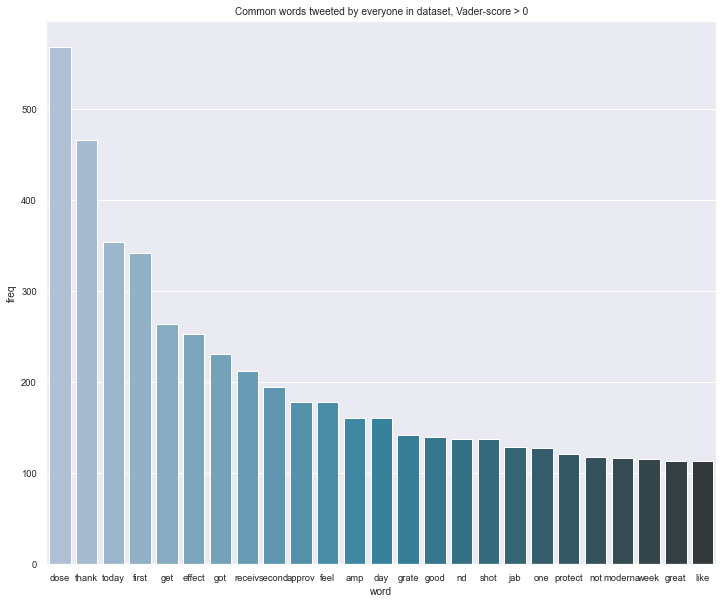

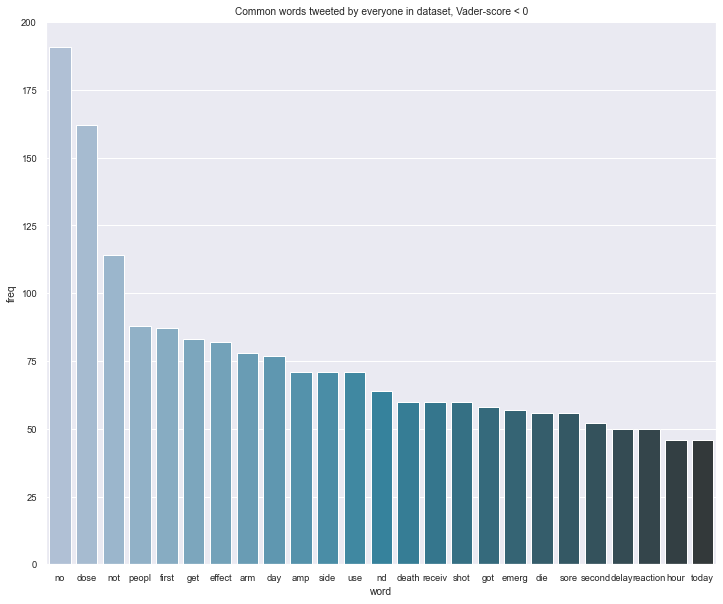

In [27]:
cleaned_text = pd.DataFrame(columns=['sentence','vader_score'])
cleaned_text['vader_score']  = tweet_data['VADER tweet']
cleaned_text['sentence']  = tweet_data['text']

dataframe = cleaned_text
how_many_words = 25
tweet_id_in_df = 'vader_score'


class CleanText(BaseEstimator, TransformerMixin):
           
#Original cleanup script inspired by my university's NLP tutorial lesson, heavily edited.

    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    #uninteresting words, found via trial and error
    def remove_common_words(self, input_text):
        common_list = ['covid','pfizer','pfizerbiontech','vaccin','covidvaccin','biontech','coronaviru','http','co','pfizervaccin','astrazeneca']
        whitelist2 = []
        words = input_text.split() 
        clean_words = [word for word in words if (word not in common_list or word in whitelist2) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming).apply(self.remove_common_words)
        return clean_X
    
ct = CleanText()

#Good tweets, all people

sent_clean = ct.fit_transform(dataframe.loc[dataframe[tweet_id_in_df] > 0].sentence)
empty_clean = sent_clean == ''
sent_clean.loc[empty_clean] = '[no_text]'

cv = CountVectorizer()
bow = cv.fit_transform(sent_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(how_many_words), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
ax.set_title('Common words tweeted by everyone in dataset, Vader-score > 0')
plt.show();

#Bad tweets, all people

#change condition
sent_clean = ct.fit_transform(dataframe.loc[dataframe[tweet_id_in_df] < 0].sentence)
empty_clean = sent_clean == ''
sent_clean.loc[empty_clean] = '[no_text]'

cv = CountVectorizer()
bow = cv.fit_transform(sent_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(how_many_words), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
ax.set_title('Common words tweeted by everyone in dataset, Vader-score < 0')
plt.show();

#### There doesn't seem to be big difference between the two groups. The results are very predictable and interesting.

- For the tweets with positive sentiment, most common words included feelings of thankfulness and receiving their dose. Words such as "protect" and "like" were used.

- For the tweets with negative sentiment, the most common words were negatives such as no and not. There seems to be many tweets about common side effects such as "arm", "sore" and "side", referring to soreness in arm after the shot.

- The words with negative sentiment have significantly less frequency, as the sentiment is generally positive.





Good tweets, normal people


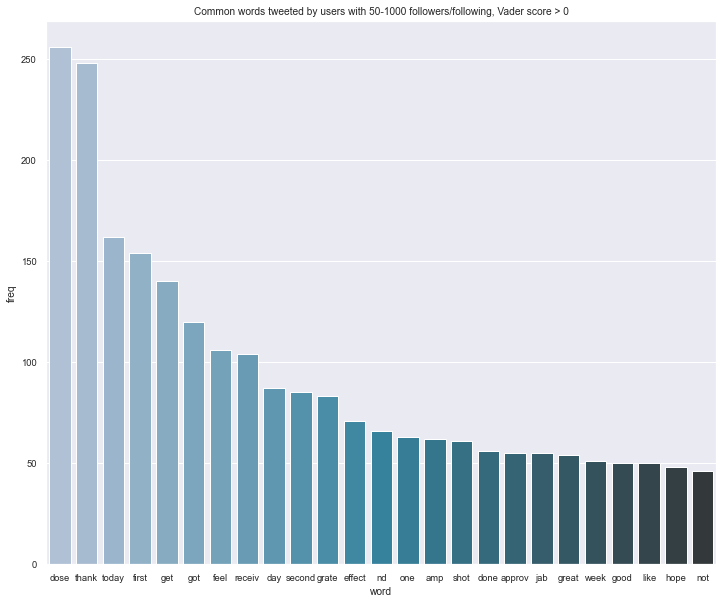

Bad tweets, normal people


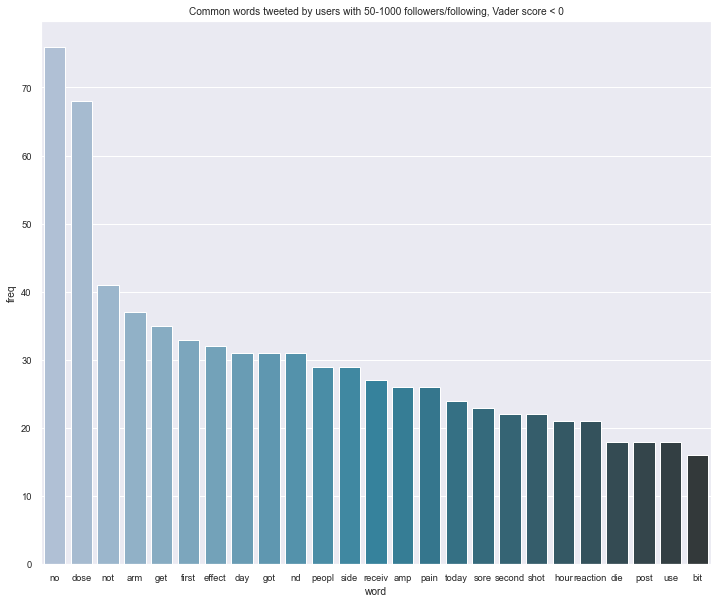

In [28]:
#Good tweets, normal people
print('Good tweets, normal people')

#adjust
dataframe = subset2
how_many_words = 25
tweet_id_in_df = 'VADER tweet'

#change condition
sent_clean = ct.fit_transform(dataframe.loc[dataframe[tweet_id_in_df] > 0].text)
empty_clean = sent_clean == ''
sent_clean.loc[empty_clean] = '[no_text]'

cv = CountVectorizer()
bow = cv.fit_transform(sent_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(how_many_words), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
ax.set_title('Common words tweeted by users with 50-1000 followers/following, Vader score > 0')
plt.show();

#Bad tweets, normal people
print('Bad tweets, normal people')

#change condition
sent_clean = ct.fit_transform(dataframe.loc[dataframe[tweet_id_in_df] < 0].text)
empty_clean = sent_clean == ''
sent_clean.loc[empty_clean] = '[no_text]'

cv = CountVectorizer()
bow = cv.fit_transform(sent_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(how_many_words), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
ax.set_title('Common words tweeted by users with 50-1000 followers/following, Vader score < 0')
plt.show();

## Conclusions

- Users in Canada were tweeting the most positive tweets about the vaccine, followed by UK, US, Malaysia and India.
- Verified users were surprisingly tweeting more negative tweets about the vaccine, this is however easily explained with the fact that many of these were news accounts.
- The followers to following ratio does not seem to play any role with the sentiment.
- The sentiment across time is quite stable and was at its highest around March, and is currently at it's lowest in August of 2021.
- The most common words for the positive tweets included feelings of thankfulness and words such as "protect".
- The most common words for the negative tweets included neutral negative words, as well as words associated with common side effects such as sore arm.




